# Room for the river: Gorssel 

## Imports 

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation

from dike_model_function import DikeNetwork  # @UnresolvedImport

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import (perform_experiments,BaseEvaluator)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench import load_results 

from mpl_toolkits.mplot3d import Axes3D 

from sklearn import preprocessing

import time
import copy

import itertools

from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import os
import functools

import random


In [2]:
from scipy.spatial.distance import pdist, squareform

def evaluate_diversity_single(indices, distances, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    i, j = [e for e in zip(*itertools.combinations(indices, 2))]
    subset_distances = distances[i, j]
    minimum = np.min(subset_distances)
    mean = np.mean(subset_distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]


def find_maxdiverse_scenarios(distances, combinations):
    scores = []
    for indices in combinations:
        diversity = evaluate_diversity_single(indices, distances)
        scores.append((diversity, indices))

    return scores

def optimize(scenario, nfe, model, converge_metrics, epsilons):
    with SequentialEvaluator(model) as evaluator:
    #with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence

def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]

In [3]:
# import the correct dataframes of a long run with 1000 scenarios and 10 policies 
df_experiments_s1000_p10 = pd.read_csv("df_experiments_s1000_p10.csv")
df_outcomes_s1000_p10 = pd.read_csv("df_outcomes_s1000_p10.csv")

## Set experiments and outcomes 

In [4]:
#check the size of the dataframes 
print(df_experiments_s1000_p10.shape) 
print(df_outcomes_s1000_p10.shape)

(10000, 54)
(10000, 18)


In [5]:
#Run MORDM with the long run as imported, copy the data here so it doesn't have to be loaded in again 
experiments = df_experiments_s1000_p10.copy()
outcomes = df_outcomes_s1000_p10.copy()

# Scenario Selection 

### Choose outcomes of interest 

While running the code below the prolem occured that the size of the outcomes was too large. The following error appeared: "The kernel for Documents/GitHub/EPA1361_group16/MORDM.ipynb appears to have died. It will restart automatically.". To prevent this from happening the choice was made to decrease the number of outcomes that will be used to 100. Ideally this wouldn't be necessary, since a large part of the data is not being used now. This can be improved upon. 



In [6]:
#Making it possible to randomly select outcomes 
set_seed = 1234567 
random.seed(set_seed)

In [7]:
#with trial and error, the number of outcomes can maximally be set to approximatly 100 
number_of_outcomes = 100 #too much: 10000,1000,500,175,174 goes well: 150, 172,173(but not the 2nd time) 
outcomes_of_interest = outcomes.sample(n=number_of_outcomes, random_state = set_seed)

y= (outcomes.index.isin(outcomes_of_interest.index))


In [8]:
experiments_of_interest = experiments.loc[y] 
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

#normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)

In [9]:
outcomes_of_interest.head()
experiments_of_interest.head()

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
106,106,31,321.087153,10.0,0.339356,94.394245,1.5,0.251813,194.392592,10.0,...,9,3,7,6,9,10,2,116,0,dikesnet
336,336,78,58.368824,1.5,0.585965,112.850913,10.0,0.609583,109.966911,1.0,...,9,3,7,6,9,10,2,346,0,dikesnet
490,490,116,221.408402,1.0,0.881096,96.943702,1.0,0.481245,238.827274,1.0,...,9,3,7,6,9,10,2,500,0,dikesnet
707,707,66,349.252960,1.5,0.565601,54.489702,10.0,0.399284,266.496110,10.0,...,9,3,7,6,9,10,2,717,0,dikesnet
744,744,93,278.838679,10.0,0.614562,142.773376,1.0,0.447878,213.345108,1.0,...,9,3,7,6,9,10,2,754,0,dikesnet


### Create Combinations 

In [10]:
# foutmelding: 
#The kernel for Documents/GitHub/EPA1361_group16/MORDM.ipynb appears to have died. It will restart automatically. 

n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 5

n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

In [11]:
#sampled_combinations = random.sample(combinations, 100) #In case there are too many combinations 
len(combinations)

75287520

In [12]:
distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)


#Difference ProcessPool en ThreadPool 
# https://superfastpython.com/threadpoolexecutor-vs-processpoolexecutor/#Comparison_of_ThreadPoolExecutor_vs_ProcessPoolExecutor
#with ProcessPoolExecutor(max_workers=cores) as executor:

with ThreadPoolExecutor(max_workers=cores) as executor:
    worker_data = np.array_split(combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))
    

In [13]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([2.188436271412426], array([14, 45, 87, 90, 91]))

### create scenarios 

In [14]:
selected = experiments.loc[most_diverse[1], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [15]:
# Show what the scenarios entail 

# scenarios

In [16]:
keys_notscenario = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', 
               '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', 
               '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 
              'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 
              'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 
              'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 
              'EWS_DaysToThreat', 'scenario', 'policy','model']

In [17]:
#create dictionary with only the uncertainties 
for i in range(0,5):
    entries_to_remove(keys_notscenario, scenarios[i]) 

scenario_1 = scenarios[1]
scenario_1

Scenario({'A.0_ID flood wave shape': 117, 'A.1_Bmax': 242.9528297674285, 'A.1_Brate': 10.0, 'A.1_pfail': 0.4452023806799587, 'A.2_Bmax': 203.71891394602457, 'A.2_Brate': 1.0, 'A.2_pfail': 0.1579972966826894, 'A.3_Bmax': 85.60140905242505, 'A.3_Brate': 1.5, 'A.3_pfail': 0.3231152824709321, 'A.4_Bmax': 335.1887778239524, 'A.4_Brate': 1.0, 'A.4_pfail': 0.5415761667050393, 'A.5_Bmax': 30.373332625601503, 'A.5_Brate': 1.0, 'A.5_pfail': 0.4619960275175704, 'discount rate 0': 2.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5})

In [18]:
scenarios

[Scenario({'A.0_ID flood wave shape': 22, 'A.1_Bmax': 181.16308821650483, 'A.1_Brate': 10.0, 'A.1_pfail': 0.5104251476977022, 'A.2_Bmax': 220.68878105905995, 'A.2_Brate': 10.0, 'A.2_pfail': 0.9786011735583656, 'A.3_Bmax': 218.1638917684424, 'A.3_Brate': 10.0, 'A.3_pfail': 0.4522507725200962, 'A.4_Bmax': 64.98261769390427, 'A.4_Brate': 1.0, 'A.4_pfail': 0.3837234873535599, 'A.5_Bmax': 167.88086310933343, 'A.5_Brate': 10.0, 'A.5_pfail': 0.1323735408571761, 'discount rate 0': 1.5, 'discount rate 1': 4.5, 'discount rate 2': 2.5}),
 Scenario({'A.0_ID flood wave shape': 117, 'A.1_Bmax': 242.9528297674285, 'A.1_Brate': 10.0, 'A.1_pfail': 0.4452023806799587, 'A.2_Bmax': 203.71891394602457, 'A.2_Brate': 1.0, 'A.2_pfail': 0.1579972966826894, 'A.3_Bmax': 85.60140905242505, 'A.3_Brate': 1.5, 'A.3_pfail': 0.3231152824709321, 'A.4_Bmax': 335.1887778239524, 'A.4_Brate': 1.0, 'A.4_pfail': 0.5415761667050393, 'A.5_Bmax': 30.373332625601503, 'A.5_Brate': 1.0, 'A.5_pfail': 0.4619960275175704, 'discount r

In [25]:
df_scenarios = pd.DataFrame(scenarios) 
df_scenarios.to_csv("scenarios_100_s1000_p10.csv") 

# Mordm Run 

### Hypervolume determination 

In [28]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

In [ ]:
start_seq_hyp = time.time()

In [29]:
results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=[0,]*len(dike_model.outcomes), 
                                       maximum=[1000,]*len(dike_model.outcomes)),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 1000, dike_model, convergence_metrics, epsilons))

1091it [25:55,  1.43s/it]                                                      
[MainProcess/INFO] optimization completed, found 563 solutions
1094it [22:51,  1.25s/it]                                                      
[MainProcess/INFO] optimization completed, found 405 solutions
1094it [22:49,  1.25s/it]                                                      
[MainProcess/INFO] optimization completed, found 262 solutions
1094it [22:58,  1.26s/it]                                                      
[MainProcess/INFO] optimization completed, found 762 solutions
1093it [22:48,  1.25s/it]                                                      
[MainProcess/INFO] optimization completed, found 496 solutions


In [ ]:
end_seq_hyp = time.time()
time_hyp = end_seq_hyp - start_seq_hyp
print(time_hyp) 

In [32]:
results

[(     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
  0          1        0        1        1        0        1        0        1   
  1          0        1        1        0        0        0        0        1   
  2          1        1        1        1        1        0        1        0   
  3          0        0        1        1        1        1        1        0   
  4          0        1        1        0        0        0        1        0   
  ..       ...      ...      ...      ...      ...      ...      ...      ...   
  558        1        0        0        0        0        1        0        0   
  559        1        1        1        0        1        1        1        1   
  560        0        0        0        0        0        1        0        1   
  561        1        1        0        0        1        0        1        0   
  562        1        1        0        0        0        0        0        1   
  
       2_RfR 2  3_RfR 0  

In [30]:
df_results = pd.DataFrame(results) 
df_results.to_csv("results_hypervolume_noo100_nfe1000_s1000_p10.csv") #save the dataframes
# #df_outcomes_s1000_p10.to_csv("df_outcomes_s1000_p10.csv")

### Epsilon volume determination 

In [34]:
#start_seq_epsilon = time.time()

In [35]:
# ema_logging.log_to_stderr(ema_logging.INFO)
# choice_nfe = 1000 #5e3
# results_epsilon = []

# for scenario in scenarios:
#     with MultiprocessingEvaluator(dike_model) as evaluator:
#         results_epsilon.append(evaluator.optimize(nfe=choice_nfe, searchover='levers',
#                                                   epsilons=[1,]*len(dike_model.outcomes),reference = scenario))

[MainProcess/INFO] pool started with 8 workers
1095it [05:42,  3.20it/s]                                                      
[MainProcess/INFO] optimization completed, found 589 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
1098it [05:59,  3.05it/s]                                                      
[MainProcess/INFO] optimization completed, found 404 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
1093it [05:59,  3.04it/s]                                                      
[MainProcess/INFO] optimization completed, found 291 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
1097it [06:07,  2.98it/s]                                                      
[MainProcess/INFO] optimization completed, found 905 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
1098it [06:00,  3.04it/s]                        

In [36]:
# end_seq_epsilon = time.time()
# time_epsilon = end_seq_epsilon - start_seq_epsilon
# print(time_epsilon) 

1847.892187833786


In [37]:
# df_results_epsilon = pd.DataFrame(results_epsilon) 
# df_results_epsilon.to_csv("results_epsilon_noo100_nfe1000_s1000_p10.csv") #save the dataframes
# # #df_outcomes_s1000_p10.to_csv("df_outcomes_s1000_p10.csv")

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [39]:
# df_results_epsilon

,0
0,0_RfR 0 0_RfR 1 0_RfR 2 1_RfR 0 1_RfR...
1,0_RfR 0 0_RfR 1 0_RfR 2 1_RfR 0 1_RfR...
2,0_RfR 0 0_RfR 1 0_RfR 2 1_RfR 0 1_RfR...
3,0_RfR 0 0_RfR 1 0_RfR 2 1_RfR 0 1_RfR...
4,0_RfR 0 0_RfR 1 0_RfR 2 1_RfR 0 1_RfR...


## Plots 

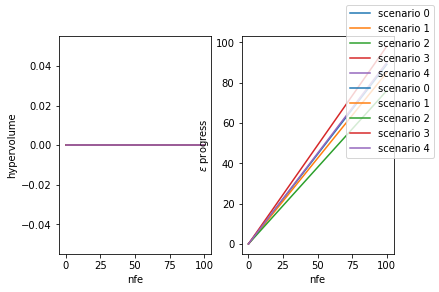

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()
#plt.savefig('Hypervol_noo100_nfe1000_and_epsilon_')

Index(['1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs',
       'A.5_Exp

In [109]:
parcoords.get_limits(results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
        'Expected Evacuation Costs']])

,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,Expected Evacuation Costs
0,0.000000e+00,0.000000,0.000000
1,1.249607e+07,0.001628,34904.097971


In [106]:
limits

,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.0,2.511400e+07,0.0,454300000.0,0.0
1,0.0,0.000000e+00,0.0,0.0,0.0


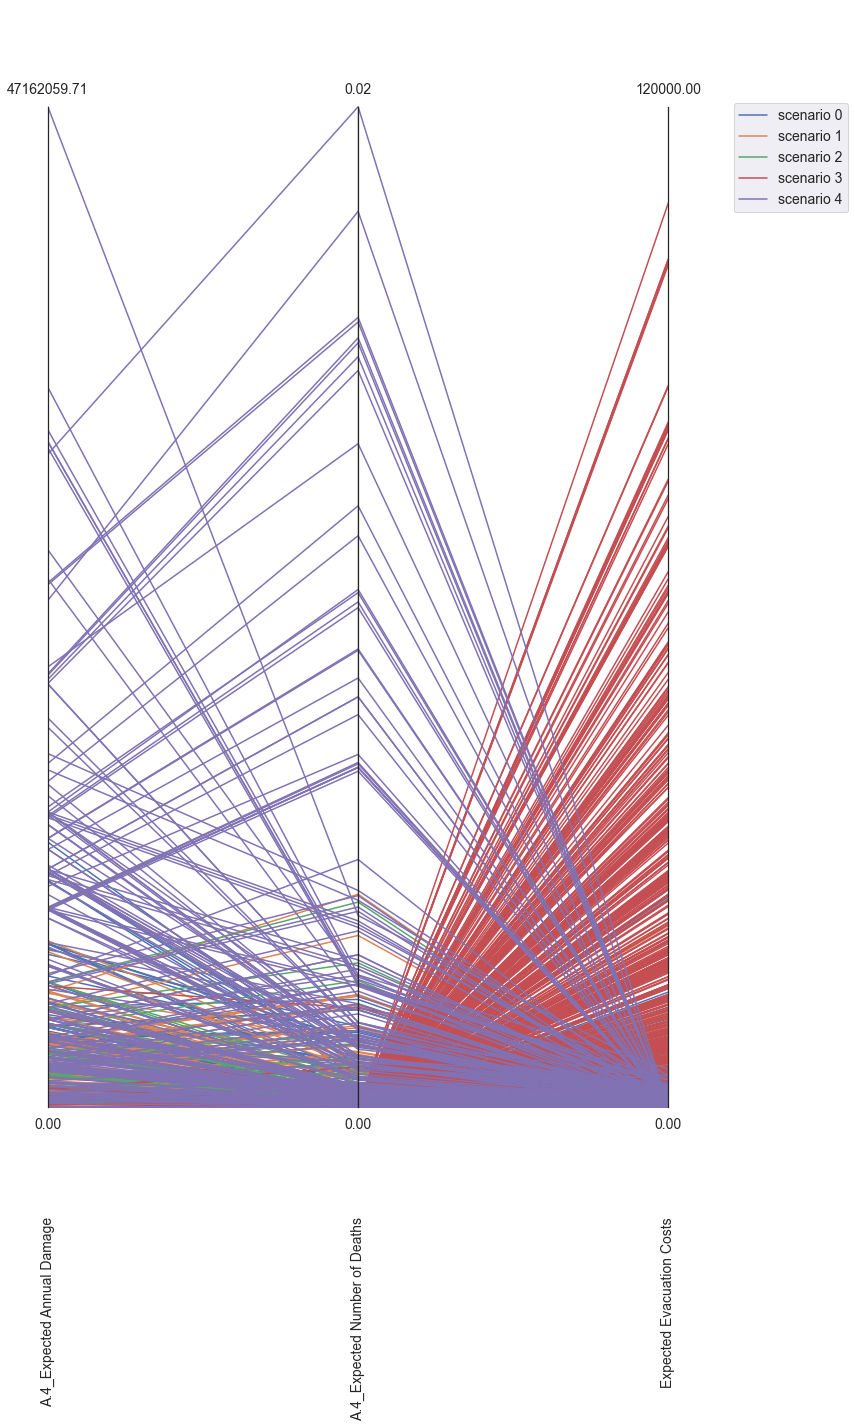

In [116]:
outcomes[['A.4_Expected Annual Damage','A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
          'RfR Total Costs','Expected Evacuation Costs']]

#determine thresholds Based on table 4.3 from report 

max_expected_annual_damage = float(data[['A.4_Expected Annual Damage']].max()) # 4.716206e+07#9.28e+05
max_number_deaths = float(data[['A.4_Expected Number of Deaths']].max()) # 0.015108 #0.00009
max_evacuation_costs = 120000#float(data[['Expected Evacuation Costs']].max()) # 4598.110276 #44826.61#4000

max_rfr_costs = 200000
max_dike_investement = 10000


colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
        'Expected Evacuation Costs']])

limits.loc[0, 'A.4_Expected Annual Damage'] = max_expected_annual_damage
limits.loc[0, 'A.4_Expected Number of Deaths'] = max_number_deaths 
limits.loc[0, 'Expected Evacuation Costs'] = max_evacuation_costs 
limits.loc[1, :] = 0

paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    sns.set(rc = {'figure.figsize':(10,20)})
    # limits = parcoords.get_limits(data[['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
    #       'Expected Evacuation Costs']])
    # limits.loc[1, 'A.4_Expected Annual Damage'] = max_expected_annual_damage
    # limits.loc[1, 'A.4_Expected Number of Deaths'] = max_number_deaths 
    # limits.loc[1, 'Expected Evacuation Costs'] = max_evacuation_costs 
    # paraxes = parcoords.ParallelAxes(limits)
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()



In [117]:
df_results.shape

(5, 2)

In [125]:
results

[(     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
  0          1        0        1        1        0        1        0        1   
  1          0        1        1        0        0        0        0        1   
  2          1        1        1        1        1        0        1        0   
  3          0        0        1        1        1        1        1        0   
  4          0        1        1        0        0        0        1        0   
  ..       ...      ...      ...      ...      ...      ...      ...      ...   
  558        1        0        0        0        0        1        0        0   
  559        1        1        1        0        1        1        1        1   
  560        0        0        0        0        0        1        0        1   
  561        1        1        0        0        1        0        1        0   
  562        1        1        0        0        0        0        0        1   
  
       2_RfR 2  3_RfR 0  

In [126]:
data.columns

Index(['1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs',
       'A.5_Exp

## Deep Uncertainty 

In [129]:
# #specify the policies 

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)
        

In [136]:
outcomes_check = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 31:48]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        outcomes_check.append(policy)

In [146]:
iets = outcomes_check[0]#['A.1_Expected Annual Damage']
iets
#outcomes_check

Policy({'A.1_Expected Annual Damage': 0.0, 'A.1_Dike Investment Costs': 126556908.17246997, 'A.1_Expected Number of Deaths': 0.0, 'A.2_Expected Annual Damage': 0.0, 'A.2_Dike Investment Costs': 93427003.66768599, 'A.2_Expected Number of Deaths': 0.0, 'A.3_Expected Annual Damage': 0.0, 'A.3_Dike Investment Costs': 101040850.71298225, 'A.3_Expected Number of Deaths': 0.0, 'A.4_Expected Annual Damage': 3770670.0919247284, 'A.4_Dike Investment Costs': 25500406.6032173, 'A.4_Expected Number of Deaths': 0.00017314316864434448, 'A.5_Expected Annual Damage': 0.0, 'A.5_Dike Investment Costs': 132217585.62532932, 'A.5_Expected Number of Deaths': 0.0, 'RfR Total Costs': 756700000.0, 'Expected Evacuation Costs': 230.948426256918})

In [153]:
sampled_policies = random.sample(policies, 50)

len(sampled_policies)
#sampled_policies

In [155]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(100, policies=sampled_policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 50 policies * 1 model(s) = 5000 experiments

100%|██████████████████████████████████████| 5000/5000 [28:29<00:00,  2.93it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.



In [156]:

experiments_deep, outcomes_deep = reeevaluation_results

#determine thresholds Based on table 4.3 from report 

max_expected_annual_damage = 9.28e+05
max_number_deaths = 0.00009
max_evacuation_costs = 4000

#max_dike_investement = 10000
#max_rfr_costs = 200000

#as defined earlier: 
thresholds = {'A.4_Expected Number of Deaths':max_number_deaths, 
              'A.4_Expected Annual Damage':max_expected_annual_damage,
             'Expected Evacuation Costs':max_evacuation_costs}

overall_scores = {}
for policy in experiments_deep.policy.unique():
    logical = experiments_deep.policy == policy
    scores = {}
    for k, v in outcomes_deep.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

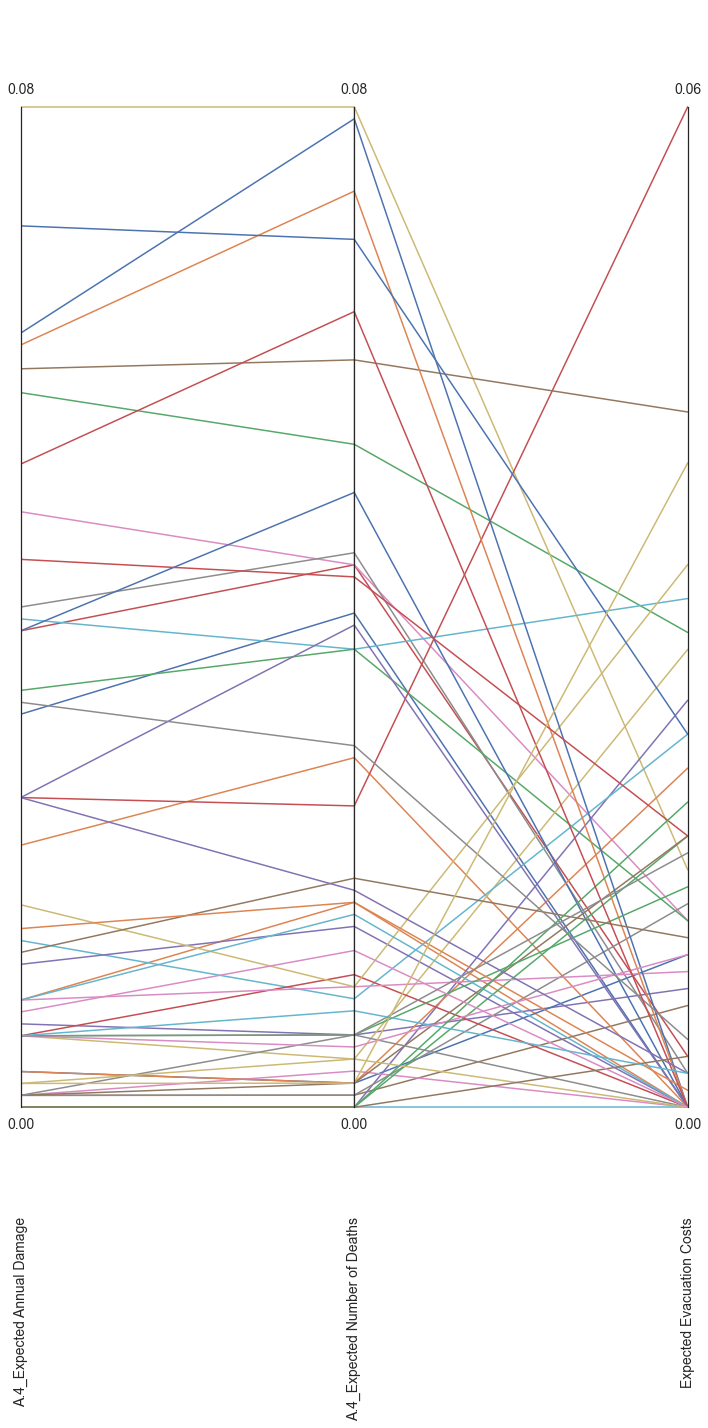

In [157]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

Alternative way?? 

In [185]:
# overall_scores = {}
# regret = []
# #a = temp_results['A.4_Expected Number of Deaths'] 

# for scenario in experiments_deep.scenario.unique():
#     logical = experiments_deep.scenario==scenario
#     temp_results = {k:v[logical] for k,v in outcomes_deep.items()}
#     temp_results = pd.DataFrame(temp_results)
#     temp_experiments = experiments_deep[experiments_deep.scenario==scenario]
        
#     best = temp_results.max()
#     best['A.4_Expected Number of Deaths'] = temp_results['A.4_Expected Number of Deaths'].min()
#     scenario_regret = a - best
#     scenario_regret['policy'] = temp_experiments.policy.values    
#     regret.append(scenario_regret)



In [188]:
# regret = pd.concat(regret)
# regret
# #maxregret = regret.groupby('policy').max()

In [189]:
# limits = parcoords.get_limits(maxregret)
# paraxes = parcoords.ParallelAxes(maxregret)
# paraxes.plot(maxregret)
# plt.show()